<a href="https://colab.research.google.com/github/LovingChester/mlportfolio/blob/main/BeijingPM2_5_mltask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Beijing PM2.5 data ML task
This notebook intends to perform regression task on the Beijing PM2.5 dataset. The dataset is provided by https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import scipy.stats as st

#### Read Dataset

In [2]:
PRSA_df = pd.read_csv('drive/MyDrive/ML_dataset/PRSA_data_2010.1.1-2014.12.31.csv')
PRSA_df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


#### EDA

In [3]:
PRSA_df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [4]:
PRSA_df.isnull().sum()

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

We have to first deal with the null value first. Given it is a time-series dataset, we can do interpolate.

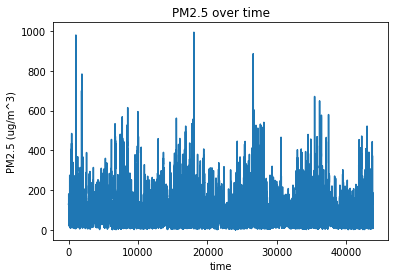

In [5]:
PRSA_df['pm2.5'] = PRSA_df['pm2.5'].interpolate(method='linear', 
                                                limit_direction='both', 
                                                axis=0)
plt.title('PM2.5 over time')
plt.xlabel('time')
plt.ylabel('PM2.5 (ug/m^3)')
plt.plot(PRSA_df['pm2.5'])
plt.show()

Plot the distribution for each attribute. We can ignore the first 5 attribute, since they are just row number and time.

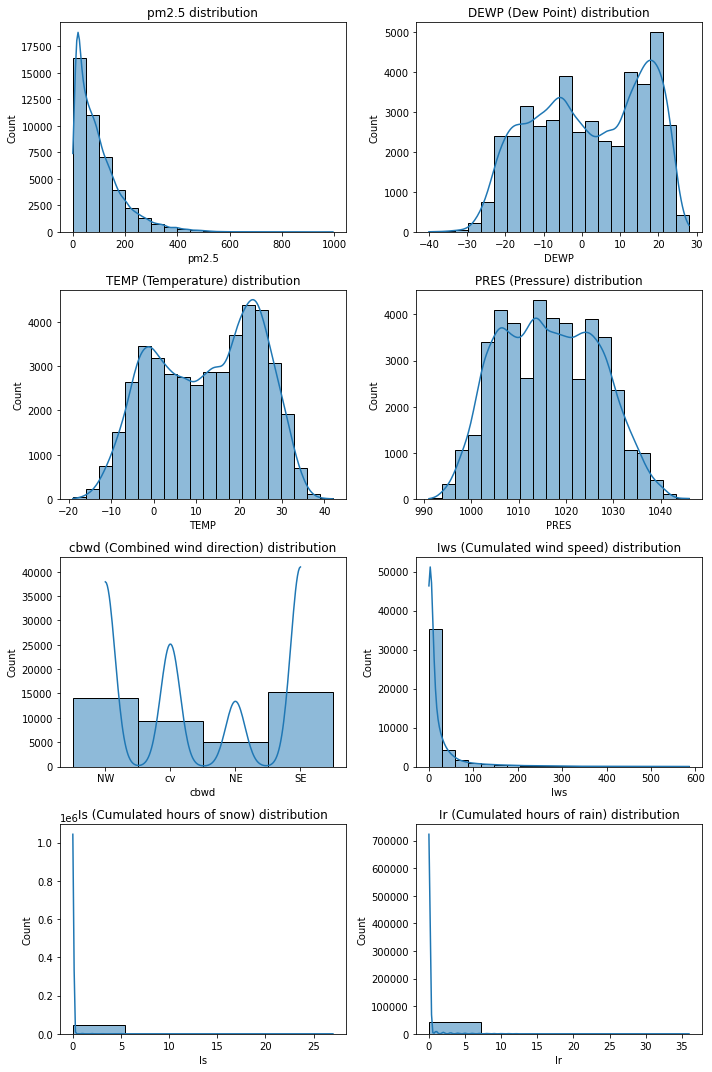

In [6]:
fig = plt.figure(figsize=(10, 15), tight_layout=True)

plt.subplot(421)
plt.title('pm2.5 distribution')
sns.histplot(PRSA_df['pm2.5'], kde=True, bins=20)

plt.subplot(422)
plt.title('DEWP (Dew Point) distribution')
sns.histplot(PRSA_df['DEWP'], kde=True, bins=20)

plt.subplot(423)
plt.title('TEMP (Temperature) distribution')
sns.histplot(PRSA_df['TEMP'], kde=True, bins=20)

plt.subplot(424)
plt.title('PRES (Pressure) distribution')
sns.histplot(PRSA_df['PRES'], kde=True, bins=20)

plt.subplot(425)
plt.title('cbwd (Combined wind direction) distribution')
sns.histplot(PRSA_df['cbwd'], kde=True, bins=20)

plt.subplot(426)
plt.title('Iws (Cumulated wind speed) distribution')
sns.histplot(PRSA_df['Iws'], kde=True, bins=20)

plt.subplot(427)
plt.title('Is (Cumulated hours of snow) distribution')
sns.histplot(PRSA_df['Is'], kde=True, bins=5)

plt.subplot(428)
plt.title('Ir (Cumulated hours of rain) distribution')
sns.histplot(PRSA_df['Ir'], kde=True, bins=5)

plt.show()

#### Correlation Heatmap

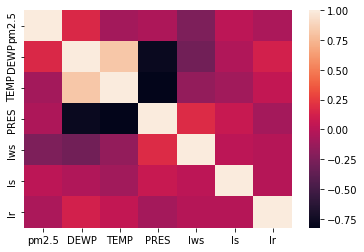

In [7]:
sns.heatmap(PRSA_df.iloc[:, 5:].corr())
plt.show()

#### Feature Selection
We will try Random Forest to select the feature, as the algorithm will automatically calaulate the importance of each feature.

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

PRSA_df_d = PRSA_df.drop(['No', 'year', 'month', 'day', 'hour', 'cbwd'], axis=1)

RF = RandomForestRegressor(random_state=1, max_depth=10)
sfm = SelectFromModel(RF)
feature = sfm.fit_transform(PRSA_df_d.iloc[:, 1:], PRSA_df_d['pm2.5'])
feature

array([[-21.  , -11.  ,   1.79],
       [-21.  , -12.  ,   4.92],
       [-21.  , -11.  ,   6.71],
       ...,
       [-22.  ,  -3.  , 242.7 ],
       [-22.  ,  -4.  , 246.72],
       [-21.  ,  -3.  , 249.85]])

#### GRU to perform time series regression

In [9]:
class GRU(nn.Module):
    def __init__(self, in_dim, gru_hidden_dim, mlp_hidden_dim, out_dim=1):

        super(GRU, self).__init__()

        self.gru = nn.GRU(input_size=in_dim, hidden_size=gru_hidden_dim,
                            batch_first=True)
        
        self.fc1 = nn.Linear(gru_hidden_dim, mlp_hidden_dim)

        self.dp = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(mlp_hidden_dim, out_dim)
        
    def forward(self, x):

        output, gru_h = self.gru(x)

        x = F.relu(self.fc1(gru_h[0]))

        x = self.dp(x)

        x = self.fc2(x)

        return x

Dataset class

In [10]:
from torch.utils.data import Dataset

class PRSA_Dataset(Dataset):
    def __init__(self, X, y, seq_len):
        
        super(PRSA_Dataset, self).__init__()
        
        self.X = []
        self.y = []

        for i in range(len(X)-seq_len):
            self.X.append(X[i:(i+seq_len)])
            self.y.append(y[i+seq_len])

        self.X = torch.tensor(np.array(self.X), dtype=torch.float)
        self.y = torch.tensor(np.array(self.y), dtype=torch.float)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

using device: cuda:0


Set up Parameters for GRU

In [12]:
in_dim = feature.shape[1]
gru_hidden_dim = 8
mlp_hidden_dim = 16
learning_rate = 0.01
seq_len = 10

Training Function

In [13]:
def train(train_loader, model):
    final_loss = None
    epochs = 200
    for epoch in tqdm(range(1, epochs + 1)):
        sum_loss = 0.
        for batch_idx, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            output = model(X)

            loss = F.mse_loss(output, y)

            sum_loss += loss.item()

            loss.backward()
            optimizer.step()

        sum_loss /= len(train_loader)
        # if epoch % 100 == 0:
        #     print(f'Epoch: {epoch}, Loss: {sum_loss:.3f}')
        
        final_loss = sum_loss
        
    #print(f'Loss: {final_loss:.3f}')

    return

Validation and Testing Function

In [14]:
def valid_test(data_loader, model):
    loss = 0
    true = []
    pred = []
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)

            output = model(X)

            true.extend(y.cpu().detach().tolist())
            pred.extend(output.cpu().detach().tolist())
            loss += torch.sqrt(F.mse_loss(output, y))

        loss /= len(data_loader)
        
    return loss, true, pred

Data spliting

In [15]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = np.concatenate((feature, PRSA_df_d['pm2.5'].to_numpy().reshape((-1, 1))),
                      axis=1)

# apply standard scaler
ss_scaler = StandardScaler()
data = ss_scaler.fit_transform(data)

X = data[:, 0:-1]
y = data[:, -1:]

# 70% of data for training
X_train = X[:int(len(X)*0.7)]
y_train = y[:int(len(X)*0.7)]
dataset_train = PRSA_Dataset(X_train, y_train, seq_len)
train_loader = du.DataLoader(dataset=dataset_train,
                            batch_size=200, shuffle=True)

# X_valid = X[int(len(X)*0.7):int(len(X)*0.9)]
# y_valid = y[int(len(X)*0.7):int(len(X)*0.9)]
# dataset_valid = PRSA_Dataset(X_valid, y_valid, seq_len)
# valid_loader = du.DataLoader(dataset=dataset_valid,
#                                 batch_size=200, shuffle=True)

# Use the rest of data for test
X_test = X[int(len(X)*0.7):]
y_test = y[int(len(X)*0.7):]
dataset_test = PRSA_Dataset(X_test, y_test, seq_len)
test_loader = du.DataLoader(dataset=dataset_test,
                             batch_size=200, shuffle=False)

#### Training and validation

In [16]:
preds = np.zeros((len(X_test)-seq_len, 1))
losses = []
models = []
# Repeat the training and validation for this much time
repeat = 50
for i in range(repeat):
    model = GRU(in_dim, gru_hidden_dim, mlp_hidden_dim)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    train(train_loader, model)

    model.eval()
    loss, true, pred = valid_test(test_loader, model)
    preds += pred
    losses.append(float(loss.cpu().detach()))
    print(f'Trial {i+1}, test RMSE loss: {loss:.3f}')

    models.append(model)
    
preds /= repeat

100%|██████████| 200/200 [02:09<00:00,  1.55it/s]


Trial 1, test RMSE loss: 0.723


100%|██████████| 200/200 [02:08<00:00,  1.56it/s]


Trial 2, test RMSE loss: 0.703


100%|██████████| 200/200 [02:09<00:00,  1.55it/s]


Trial 3, test RMSE loss: 0.706


100%|██████████| 200/200 [02:08<00:00,  1.55it/s]


Trial 4, test RMSE loss: 0.725


100%|██████████| 200/200 [02:09<00:00,  1.54it/s]


Trial 5, test RMSE loss: 0.710


100%|██████████| 200/200 [02:08<00:00,  1.55it/s]


Trial 6, test RMSE loss: 0.723


100%|██████████| 200/200 [02:08<00:00,  1.56it/s]


Trial 7, test RMSE loss: 0.700


100%|██████████| 200/200 [02:08<00:00,  1.55it/s]


Trial 8, test RMSE loss: 0.711


100%|██████████| 200/200 [02:08<00:00,  1.56it/s]


Trial 9, test RMSE loss: 0.706


100%|██████████| 200/200 [02:08<00:00,  1.56it/s]


Trial 10, test RMSE loss: 0.720


100%|██████████| 200/200 [02:09<00:00,  1.54it/s]


Trial 11, test RMSE loss: 0.704


100%|██████████| 200/200 [02:10<00:00,  1.54it/s]


Trial 12, test RMSE loss: 0.712


100%|██████████| 200/200 [02:09<00:00,  1.54it/s]


Trial 13, test RMSE loss: 0.728


100%|██████████| 200/200 [02:09<00:00,  1.54it/s]


Trial 14, test RMSE loss: 0.704


100%|██████████| 200/200 [02:10<00:00,  1.53it/s]


Trial 15, test RMSE loss: 0.701


100%|██████████| 200/200 [02:10<00:00,  1.53it/s]


Trial 16, test RMSE loss: 0.713


100%|██████████| 200/200 [02:10<00:00,  1.53it/s]


Trial 17, test RMSE loss: 0.710


100%|██████████| 200/200 [02:10<00:00,  1.53it/s]


Trial 18, test RMSE loss: 0.695


100%|██████████| 200/200 [02:10<00:00,  1.54it/s]


Trial 19, test RMSE loss: 0.698


100%|██████████| 200/200 [02:10<00:00,  1.53it/s]


Trial 20, test RMSE loss: 0.707


100%|██████████| 200/200 [02:10<00:00,  1.54it/s]


Trial 21, test RMSE loss: 0.736


100%|██████████| 200/200 [02:09<00:00,  1.54it/s]


Trial 22, test RMSE loss: 0.714


100%|██████████| 200/200 [02:09<00:00,  1.54it/s]


Trial 23, test RMSE loss: 0.702


100%|██████████| 200/200 [02:09<00:00,  1.54it/s]


Trial 24, test RMSE loss: 0.696


100%|██████████| 200/200 [02:09<00:00,  1.55it/s]


Trial 25, test RMSE loss: 0.740


100%|██████████| 200/200 [02:10<00:00,  1.54it/s]


Trial 26, test RMSE loss: 0.707


100%|██████████| 200/200 [02:10<00:00,  1.54it/s]


Trial 27, test RMSE loss: 0.719


100%|██████████| 200/200 [02:09<00:00,  1.54it/s]


Trial 28, test RMSE loss: 0.714


100%|██████████| 200/200 [02:10<00:00,  1.54it/s]


Trial 29, test RMSE loss: 0.712


100%|██████████| 200/200 [02:10<00:00,  1.53it/s]


Trial 30, test RMSE loss: 0.720


100%|██████████| 200/200 [02:10<00:00,  1.53it/s]


Trial 31, test RMSE loss: 0.716


100%|██████████| 200/200 [02:11<00:00,  1.53it/s]


Trial 32, test RMSE loss: 0.703


100%|██████████| 200/200 [02:10<00:00,  1.53it/s]


Trial 33, test RMSE loss: 0.717


100%|██████████| 200/200 [02:09<00:00,  1.54it/s]


Trial 34, test RMSE loss: 0.700


100%|██████████| 200/200 [02:09<00:00,  1.55it/s]


Trial 35, test RMSE loss: 0.741


100%|██████████| 200/200 [02:09<00:00,  1.54it/s]


Trial 36, test RMSE loss: 0.714


100%|██████████| 200/200 [02:10<00:00,  1.53it/s]


Trial 37, test RMSE loss: 0.713


100%|██████████| 200/200 [02:09<00:00,  1.55it/s]


Trial 38, test RMSE loss: 0.708


100%|██████████| 200/200 [02:09<00:00,  1.55it/s]


Trial 39, test RMSE loss: 0.710


100%|██████████| 200/200 [02:09<00:00,  1.55it/s]


Trial 40, test RMSE loss: 0.701


100%|██████████| 200/200 [02:09<00:00,  1.54it/s]


Trial 41, test RMSE loss: 0.711


100%|██████████| 200/200 [02:08<00:00,  1.55it/s]


Trial 42, test RMSE loss: 0.712


100%|██████████| 200/200 [02:10<00:00,  1.54it/s]


Trial 43, test RMSE loss: 0.702


100%|██████████| 200/200 [02:10<00:00,  1.54it/s]


Trial 44, test RMSE loss: 0.719


100%|██████████| 200/200 [02:10<00:00,  1.53it/s]


Trial 45, test RMSE loss: 0.711


100%|██████████| 200/200 [02:11<00:00,  1.53it/s]


Trial 46, test RMSE loss: 0.714


100%|██████████| 200/200 [02:09<00:00,  1.54it/s]


Trial 47, test RMSE loss: 0.726


100%|██████████| 200/200 [02:10<00:00,  1.53it/s]


Trial 48, test RMSE loss: 0.719


100%|██████████| 200/200 [02:10<00:00,  1.54it/s]


Trial 49, test RMSE loss: 0.706


100%|██████████| 200/200 [02:10<00:00,  1.54it/s]


Trial 50, test RMSE loss: 0.683


##### Validation Error Distribution

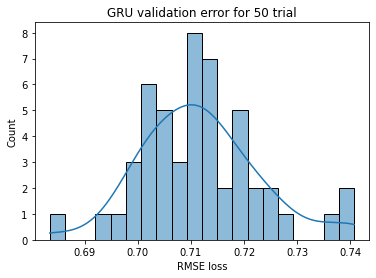

In [17]:
plt.title('GRU validation error for 50 trial')
plt.xlabel('RMSE loss')
sns.histplot(losses, kde=True, bins=20)

In [18]:
pd.DataFrame(losses).describe()

,0
count,50.000000
mean,0.711687
std,0.011167
min,0.683440
25%,0.703591
50%,0.710967
75%,0.718344
max,0.740723


In [19]:
st.t.interval(alpha=0.95, df=len(losses)-1, loc=np.mean(losses), scale=st.sem(losses))

(0.7085135568026287, 0.7148606502171772)

Setting the significance level be 0.05, we have 95% confidence to say that the expected validation error lies between 0.709 and 0.715

#### Testing

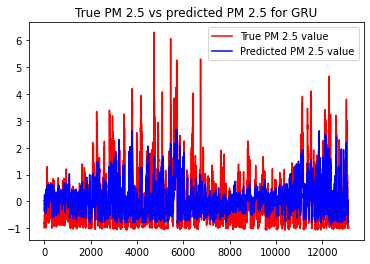

In [20]:
plt.title('True PM 2.5 vs predicted PM 2.5 for GRU')
plt.plot(true, c='r', label='True PM 2.5 value')
plt.plot(preds, c='b', label='Predicted PM 2.5 value')
plt.legend()
plt.show()

#### CNN approach
Try CNN time series approach, see if it is better than GRU.

In [21]:
class Cnn(nn.Module):
    def __init__(self, in_channels, out_channels, k_size, stride, padding, 
                 mlp_hidden_dim, seq_len):

        super(Cnn, self).__init__()

        self.conv1d = nn.Conv1d(in_channels, out_channels, k_size, 
                                stride=stride, padding=padding)

        self.dp = nn.Dropout(p=0.2)
        
        self.maxpool = nn.MaxPool1d(k_size, stride=1, padding=1)

        self.flatten = nn.Flatten()

        #in_dim = int(seq_len - k_size) + 1
        in_dim = int((seq_len + 2 * padding - 1 * (k_size - 1) - 1) / stride) + 1
        in_dim *= out_channels
        self.fc1 = nn.Linear(in_dim, mlp_hidden_dim)

        self.fc2 = nn.Linear(mlp_hidden_dim, 1)
        
    def forward(self, x):

        x = torch.transpose(x, 1, 2)
        
        x = F.relu(self.conv1d(x))

        x = self.dp(x)
        #print(x.shape)

        x = self.maxpool(x)
        #print(x.shape)

        x = self.flatten(x)
        #print(x.shape)

        x = F.relu(self.fc1(x))

        x = self.dp(x)

        x = self.fc2(x)

        return x

Set parameter for CNN

In [22]:
in_channels = feature.shape[1]
out_channels = 8
stride = 1
padding = 0
k_size = 3
mlp_hidden_dim = 16

CNN Training

In [23]:
preds = np.zeros((len(X_test)-seq_len, 1))
losses = []
models = []
# Repeat the training and validation for this much time
repeat = 50
for i in range(repeat):
    model = Cnn(in_channels, out_channels, k_size, stride, padding, 
                mlp_hidden_dim, seq_len)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    train(train_loader, model)

    model.eval()
    loss, true, pred = valid_test(test_loader, model)
    preds += pred
    losses.append(float(loss.cpu().detach()))
    print(f'Trial {i+1}, test RMSE loss: {loss:.3f}')

    models.append(model)

preds /= repeat

100%|██████████| 200/200 [02:04<00:00,  1.60it/s]


Trial 1, test RMSE loss: 0.710


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 2, test RMSE loss: 0.712


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Trial 3, test RMSE loss: 0.685


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Trial 4, test RMSE loss: 0.728


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 5, test RMSE loss: 0.691


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 6, test RMSE loss: 0.695


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 7, test RMSE loss: 0.709


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 8, test RMSE loss: 0.721


100%|██████████| 200/200 [01:59<00:00,  1.68it/s]


Trial 9, test RMSE loss: 0.704


100%|██████████| 200/200 [01:58<00:00,  1.69it/s]


Trial 10, test RMSE loss: 0.680


100%|██████████| 200/200 [01:58<00:00,  1.69it/s]


Trial 11, test RMSE loss: 0.699


100%|██████████| 200/200 [01:57<00:00,  1.70it/s]


Trial 12, test RMSE loss: 0.725


100%|██████████| 200/200 [01:58<00:00,  1.69it/s]


Trial 13, test RMSE loss: 0.701


100%|██████████| 200/200 [01:58<00:00,  1.69it/s]


Trial 14, test RMSE loss: 0.754


100%|██████████| 200/200 [01:58<00:00,  1.69it/s]


Trial 15, test RMSE loss: 0.703


100%|██████████| 200/200 [01:58<00:00,  1.69it/s]


Trial 16, test RMSE loss: 0.695


100%|██████████| 200/200 [01:58<00:00,  1.69it/s]


Trial 17, test RMSE loss: 0.688


100%|██████████| 200/200 [01:58<00:00,  1.69it/s]


Trial 18, test RMSE loss: 0.701


100%|██████████| 200/200 [01:58<00:00,  1.68it/s]


Trial 19, test RMSE loss: 0.705


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Trial 20, test RMSE loss: 0.720


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Trial 21, test RMSE loss: 0.681


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Trial 22, test RMSE loss: 0.673


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Trial 23, test RMSE loss: 0.711


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 24, test RMSE loss: 0.692


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 25, test RMSE loss: 0.708


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 26, test RMSE loss: 0.673


100%|██████████| 200/200 [02:00<00:00,  1.67it/s]


Trial 27, test RMSE loss: 0.695


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Trial 28, test RMSE loss: 0.724


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 29, test RMSE loss: 0.701


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 30, test RMSE loss: 0.680


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Trial 31, test RMSE loss: 0.706


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Trial 32, test RMSE loss: 0.684


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Trial 33, test RMSE loss: 0.706


100%|██████████| 200/200 [01:59<00:00,  1.68it/s]


Trial 34, test RMSE loss: 0.705


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Trial 35, test RMSE loss: 0.686


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Trial 36, test RMSE loss: 0.697


100%|██████████| 200/200 [02:00<00:00,  1.67it/s]


Trial 37, test RMSE loss: 0.719


100%|██████████| 200/200 [02:00<00:00,  1.67it/s]


Trial 38, test RMSE loss: 0.683


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Trial 39, test RMSE loss: 0.722


100%|██████████| 200/200 [01:59<00:00,  1.68it/s]


Trial 40, test RMSE loss: 0.700


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 41, test RMSE loss: 0.688


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 42, test RMSE loss: 0.686


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 43, test RMSE loss: 0.699


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 44, test RMSE loss: 0.733


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 45, test RMSE loss: 0.696


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 46, test RMSE loss: 0.690


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 47, test RMSE loss: 0.728


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 48, test RMSE loss: 0.697


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 49, test RMSE loss: 0.680


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Trial 50, test RMSE loss: 0.693


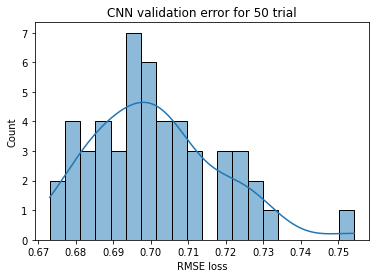

In [24]:
plt.title('CNN validation error for 50 trial')
plt.xlabel('RMSE loss')
sns.histplot(losses, kde=True, bins=20)

In [25]:
pd.DataFrame(losses).describe()

,0
count,50.000000
mean,0.701247
std,0.016849
min,0.673066
25%,0.688752
50%,0.699818
75%,0.709616
max,0.754203


In [26]:
st.t.interval(alpha=0.95, df=len(losses)-1, loc=np.mean(losses), scale=st.sem(losses))

(0.6964588984165874, 0.7060357204760823)

Setting the significance level be 0.05, we have 95% confidence to say that the expected validation error lies between 0.696 and 0.706

#### Testing

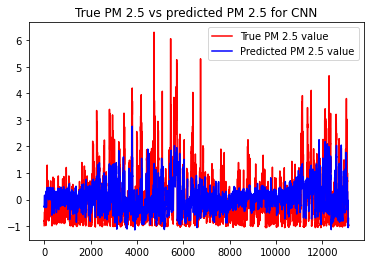

In [27]:
plt.title('True PM 2.5 vs predicted PM 2.5 for CNN')
plt.plot(true, c='r', label='True PM 2.5 value')
plt.plot(preds, c='b', label='Predicted PM 2.5 value')
plt.legend()
plt.show()

It looks like CNN performs slightly better than GRU given its smaller confidence interval